## Setup

In [321]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
import xgboost as xgb


In [5]:
# %conda install sklearn

## Data import

In [6]:
how_many_files = 4 #set maximum number of files when doing dev work 

In [7]:
#RUN
# read all sample files into memory
try: 
    del(df_cert)
    del(df_rec)
except:
    pass

files_counter = 0
for f in os.listdir('data_samples'):
    
    print(f'Processing {f}')
    
    # Certificates files
    df_cert_temp = pd.read_csv(
        f'data_samples/{f}/certificates.csv', 
        dtype = {'INSPECTION_DATE':'str','LODGEMENT_DATE':'str'},
        parse_dates=['INSPECTION_DATE','LODGEMENT_DATE'],
        low_memory=False
    )
    try:
        df_cert = pd.concat([df_cert, df_cert_temp])
    except:
         df_cert = df_cert_temp.copy()
        
    # Recommendations files
    df_rec_temp = pd.read_csv(f'data_samples/{f}/recommendations.csv', low_memory=False)
    try:
        df_rec = pd.concat([df_rec, df_rec_temp])
    except:
        df_rec = df_rec_temp.copy()
        
    print(f'Length certificates: {len(df_cert)}, Length recommendations: {len(df_rec)}')
    
    files_counter += 1
    if files_counter == how_many_files:
        break
    
df_cert.reset_index(inplace=True)
df_rec.reset_index(inplace=True)

Processing domestic-E06000001-Hartlepool
Length certificates: 42173, Length recommendations: 177258
Processing domestic-E06000002-Middlesbrough
Length certificates: 105113, Length recommendations: 443706
Processing domestic-E06000003-Redcar-and-Cleveland
Length certificates: 159295, Length recommendations: 693122
Processing domestic-E06000004-Stockton-on-Tees
Length certificates: 243123, Length recommendations: 1041647


## Cleansing NaNs

Quick cleanse to replace dubious labels with Nan.
Will do proper categories cleanse later.

In [8]:
#RUN
# create copy
cert = df_cert.copy() 

#lower case all col headers to speed up typing
cert.columns = [col.lower() for col in cert.columns]

# pd.Series(cert.columns).to_csv('columns.csv',index=False)

# replace 'NO DATA!', 'not defined' and 'not recored' with null
cert = cert.replace(['NO DATA!','NODATA!','not recorded','not defined','unknown',
                     'Unknown','Not defined','Not recorded','N/A','n/a','INVALID!'],np.nan)
print('Done 1')

# replace any values starting sap as these are the column headers not real data
cert = cert.replace([r'^SAP.*',r'^sap.*'],np.nan,regex=True)
print('Done 2')

# replace '+ Chr(13) +' as it's meaningless
cert = cert.replace([r"\+ Chr\(13\) \+",r"\+ chr\(13\) \+"],'+', regex=True)
print('Done 3')

# replacing values in columns which are actually just the column header
replacement_dict = {
    'hotwater_description':{r'^Hot-Water$':np.nan},
    'floor_description':{r'^Floor$':np.nan},
    'walls_description':{r'^Wall$':np.nan},
    'windows_description':{r'^Window$':np.nan},
    'roof_description':{r'^Roof$':np.nan},
    'main_heating_controls':{r'^Main-Heating-Controls$':np.nan},
    'secondheat_description':{r'^Secondary-Heating$':np.nan},
    'lighting_description':{r'^Lighting$':np.nan},
    'mainheatcont_description':{r'^Main-Heating-Controls$':np.nan}}

cert = cert.replace(replacement_dict,regex=True)
print('Done 4')

Done 1
Done 2
Done 3
Done 4


## Initial clean up of categorical variables

Quick clean up - will do a more thorough job further down 

#### PROPERTY_TYPE

In [9]:
#RUN
#just drop the Park Homes
cert = cert.drop(cert[cert.property_type=='Park home'].index)
cert.property_type.isna().sum()

0

#### BUILT_FORM

In [10]:
#RUN
#remove 'enclosed' from the terraced properties 

cert.built_form = cert.built_form.map({
    'Enclosed End-Terrace':'End-Terrace',
    'Enclosed Mid-Terrace':'Mid-Terrace',
    'Mid-Terrace':'Mid-Terrace',
    'Semi-Detached':'Semi-Detached',
    'End-Terrace':'End-Terrace',
    'Detached':'Detached'
})

cert.built_form.value_counts()

Semi-Detached    79242
Mid-Terrace      76134
Detached         46729
End-Terrace      37760
Name: built_form, dtype: int64

#### ENERGY_TARIFF

In [11]:
#RUN
#replace the unknowns with actual NAs

cert['energy_tariff'] = cert.energy_tariff.replace('Unknown',np.nan)

cert.energy_tariff.value_counts()

Single              189152
standard tariff      23848
dual                 13484
off-peak 7 hour       9337
off-peak 10 hour       433
24 hour                161
dual (24 hour)          78
off-peak 18 hour         7
Name: energy_tariff, dtype: int64

#### GLAZED_TYPE

In [12]:
#RUN
#remap these messy categories 
cert.glazed_type = cert.glazed_type.replace(['double, known data','secondary glazing'],'double glazing, unknown install date')
cert.glazed_type = cert.glazed_type.replace('triple, known data','triple glazing')

cert.glazed_type = cert.glazed_type.replace(['INVALID!','not defined'],np.nan)

cert.glazed_type.value_counts()

double glazing installed before 2002             75725
double glazing installed during or after 2002    69250
double glazing, unknown install date             63349
single glazing                                    1166
triple glazing                                     146
Name: glazed_type, dtype: int64

#### TENURE

In [13]:
#RUN
cert.tenure = cert.tenure.replace('unknown',np.nan)
cert.tenure = cert.tenure.replace('Not defined.*',np.nan,regex=True)
cert.tenure = cert.tenure.replace('Rented (social)','rental (social)')
cert.tenure = cert.tenure.replace('Rented (private)','rental (private)')
cert.tenure = cert.tenure.replace('Owner-occupied','owner-occupied')

cert.tenure.value_counts()

owner-occupied      117977
rental (social)      60370
rental (private)     40388
Name: tenure, dtype: int64

## Impute w/in same building 
Fill in NaNs if there is more than one certificate w/in the same building, where the attribute was populated at least once. Assumes attribute is time-invariant.

TODO: add flag for inputation to be used in the model?

In [14]:
fill_columns = ['built_form',
 'mains_gas_flag',
 'floor_level',
 'number_habitable_rooms',
 'roof_description',
 'heat_loss_corridor',
 'floor_height']

In [15]:
for col in fill_columns:
    
    print(f'Filling {col}')
    
    temp = cert[['building_reference_number','lmk_key',col]].groupby('building_reference_number').count()
    temp = temp[
        (temp.lmk_key>1)& #more than one certificate on the same building
        (temp[col]>0)& #at least one certificate with attribute populated
        (temp[col]<temp.lmk_key) #at least one certificate where attribute missing  
    ]
    
    print(f'Filling in missing values for {len(temp)} properties')
    if len(temp)==0: continue
    
    # Get filler values
    temp_lookup = cert[cert.building_reference_number.isin(temp.index)].groupby('building_reference_number')[col].agg(
        lambda x: pd.Series.mode(x)[0]) #just get the most frequent
    
    #join original table to the lookup table to get the filler values
    temp_filler = cert.loc[cert.building_reference_number.isin(temp.index) & cert[col].isna()].merge(
        temp_lookup, how='left',left_on='building_reference_number',right_index=True)[col+'_y']

    # fill in original table 
    cert.loc[cert.building_reference_number.isin(temp.index) & cert[col].isna(),col
            ] = temp_filler
    

Filling built_form
Filling in missing values for 743 properties
Filling mains_gas_flag
Filling in missing values for 1588 properties
Filling floor_level
Filling in missing values for 321 properties
Filling number_habitable_rooms
Filling in missing values for 1487 properties
Filling roof_description
Filling in missing values for 80 properties
Filling heat_loss_corridor
Filling in missing values for 649 properties
Filling floor_height
Filling in missing values for 21282 properties


## Dedupe on same date
TODO: didn't do anything with this for now. Consider later.
Quite high % of duplicates (but they could be different apartments? we do not get the apartment number).

In [16]:
len(cert[cert.duplicated(subset=['building_reference_number','inspection_date'])]) / len(cert)

0.023371751523976407

In [17]:
len(cert[cert.duplicated(subset=['uprn','inspection_date'])]) / len(cert)

0.030524774385679146

## Dropping cols that are mostly empty

TODO: Check if worth replicating this.

Not doing it for now because will treat fields differently later on.

## Clipping values

TODO: review all of these thresholds - done using analysis from DSCampus

In [18]:
def call_clip(df):
    
    ''' 
    Clips the variables of the EPC data between 0 and a specified upper amount
    '''
    
    df['current_energy_efficiency'].clip(lower = 0.0, upper = 100, inplace = True)
    df['energy_consumption_current'].clip(lower = 0.0, upper = 600, inplace = True)
    df['co2_emissions_current'].clip(lower = 0.0, upper = 20, inplace = True)
    df['co2_emiss_curr_per_floor_area'].clip(lower = 0.0, upper = 100, inplace = True)
    df['lighting_cost_current'].clip(lower = 0.0, upper = 150, inplace = True)
    df['heating_cost_current'].clip(lower = 0.0, upper = 1750, inplace = True)
    df['hot_water_cost_current'].clip(lower = 0.0, upper = 350, inplace = True)
    df['total_floor_area'].clip(lower = 10.0, upper = 175, inplace = True)
    df['multi_glaze_proportion'].clip(lower = 0.0, upper = 100, inplace = True)
    df['extension_count'].clip(lower = 0.0, upper = 4, inplace = True)
    df['number_habitable_rooms'].clip(lower = 0.0, upper = 10, inplace = True)
    df['number_heated_rooms'].clip(lower = 0.0, upper = 9, inplace = True)
    df['low_energy_lighting'].clip(lower = 0.0, upper = 100, inplace = True)
    df['number_open_fireplaces'].clip(lower = 0.0, upper = 4, inplace = True)
    df['floor_height'].clip(lower = 0.0, upper = 3, inplace = True)
    return(df)

call_clip = call_clip(cert)


## Strings cleanup 

A lot of string manipulation to clean up fields (taken mostly from DSCampus analysis).

Might not be necessary if we do not end up using the relevant variables.

#### Remove bi-lingual sentences

In [19]:
descriptive_columns = ['floor_description',
 'lighting_description',
 'roof_description',
 'walls_description',
 'windows_description',
 'hotwater_description',
 'main_heating_controls']

for col in descriptive_columns:
    cert[col] = cert[col].str.replace(r"\|(.*)","",regex=True)

#### Cleaning up units for average thermal transmittance

In [20]:
def thermal_cleanup(df):
    
    ''' 
    standardising the wording in the variables containing average thermal transmittance. Specifically, 
    removing bi-lingual versions, removing =, translating welsh version, and standardising units
    '''
    
    for c in ['floor_description','walls_description','roof_description']:
        df[c] = df[c].str.replace('  ',' ')
        df[c] = df[c].str.replace('Average thermal transmittance 1 ','Average thermal transmittance 1.00 ')
        df[c] = df[c].str.replace('Average thermal transmittance =','Average thermal transmittance')
        df[c] = df[c].str.replace('Trawsyriannedd thermol cyfartalog','Average thermal transmittance')
        # standardising the unit used
        df[c] = df[c].str.replace(r"W(.*?)K",'W/m²K',regex=True)
        
    return df

cert = thermal_cleanup(cert)

#### Floor description

In [21]:
def thermal_floor(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field to 1 decimal place
    '''
    
    # finds the decimal number
    df['floors_average_thermal_transmittance'] = df['floor_description'].str.findall(r'\d.\d*')
    # rounds the number to 1 decimal place
    df['floors_average_thermal_transmittance'] = round(df['floors_average_thermal_transmittance'].str[0].astype(float),1)
    # 
    df['floor_description'] = df.apply(lambda row: 'average thermal transmittance %.1f W/m²K' % (row['floors_average_thermal_transmittance']) if 'Average' in str(row['floor_description']) else row['floor_description'],axis=1)
    
    return df

cert = thermal_floor(cert)

In [22]:
def floor_cleanup(df):
    
    ''' 
    cleans-up the floor_description feature from the EPC dataset
    '''
    
    df['floor_description'] = df['floor_description'].str.lower()

    # translating welsh sentences
    df['floor_description'] = df['floor_description'].str.replace(r"anheddiad arall islaw",'another dwelling below') 
    df['floor_description'] = df['floor_description'].str.replace("\(eiddo arall islaw\)",'other premises below') 
    df['floor_description'] = df['floor_description'].str.replace(r"wedi(.*?)i inswleiddio","insulated")
    df['floor_description'] = df['floor_description'].str.replace("dim inswleiddio","no insulation")
    df['floor_description'] = df['floor_description'].str.replace("(rhagdybiaeth)","assumed")
    df['floor_description'] = df['floor_description'].str.replace("crog","suspended")
    df['floor_description'] = df['floor_description'].str.replace("heb ei inswleiddio","no insulation")
    df['floor_description'] = df['floor_description'].str.replace("i ofod heb ei wresogi","to unheated space")
    df['floor_description'] = df['floor_description'].str.replace("solet","solid")
    df['floor_description'] = df['floor_description'].str.replace("inswleiddio cyfyngedig","limited insulation")

    # removing assumed
    df['floor_description'] = df['floor_description'].str.replace("\(assumed\)","")

    # standardising language
    df['floor_description'] = df['floor_description'].str.replace("\(another dwelling below\)",'other premises below') 
    df['floor_description'] = df['floor_description'].str.replace("\(other premises below\)",'other premises below')
    df['floor_description'] = df['floor_description'].str.replace("solid.",'solid,') 
    df['floor_description'] = df['floor_description'].str.replace("uninsulated",'no insulation,') 
    df['floor_description'] = df['floor_description'].str.replace("insulation=100mm",'100 mm insulation') 
    df['floor_description'] = df['floor_description'].str.replace(", \(assumed\)",' (assumed)')
    df['floor_description'] = df['floor_description'].str.replace("insulation=25mm",'25 mm insulation')
    df['floor_description'] = df['floor_description'].str.replace("insulation=75mm",'75 mm insulation')
    df['floor_description'] = df['floor_description'].str.replace("limited insulated",'limited insulation')
    # cleanup
    df['floor_description'] = df['floor_description'].str.replace("[ \t]+$","")
    df['floor_description'] = df['floor_description'].str.replace(r'\,$','')
    df['floor_description'] = df['floor_description'].str.replace(r'^, ','')
    df['floor_description'] = df['floor_description'].str.replace(r'\?','')
    
    return df

cert = floor_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3060261636.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['floor_description'] = df['floor_description'].str.replace("\(eiddo arall islaw\)",'other premises below')
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3060261636.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['floor_description'] = df['floor_description'].str.replace(r"wedi(.*?)i inswleiddio","insulated")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3060261636.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['floor_description'] = df['floor_description'].str.replace("(rhagdybiaeth)","assumed")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3060261636.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['floor_description'] = df['floor_des

#### Lighting description

In [23]:
# lighting and second heat descriptions have some entries the wrong way around
cert['secondheat_description1'] = cert.apply(
    lambda row: row['lighting_description'] if 'lighting' in str(row['secondheat_description']) else row['secondheat_description'],axis = 1)
cert['lighting_description1'] = cert.apply(
    lambda row: row['secondheat_description'] if 'lighting' in str(row['secondheat_description']) else row['lighting_description'],axis = 1)

cert.drop(columns= ['secondheat_description','lighting_description'],axis=1,inplace=True)
cert.rename(columns={'secondheat_description1':'secondheat_description','lighting_description1':'lighting_description'},inplace=True)

In [24]:
def lighting_cleanup(df):
    
    ''' 
    cleans-up the lighting_description feature from the EPC dataset
    '''
    
    df['lighting_description'] = df['lighting_description'].str.lower()
    # combining ways of saying all lights are low energy
    df['lighting_description'] = df['lighting_description'].str.replace(r'goleuadau ynni-isel ym mhob un o.r mannau gosod','low energy lighting in all fixed outlets')
    df['lighting_description'] = df['lighting_description'].str.replace(r'low energy lighting in 120% of fixed outlets','low energy lighting in all fixed outlets')
    df['lighting_description'] = df['lighting_description'].str.replace(r'low energy lighting 100% of fixed outlets','low energy lighting in all fixed outlets')
    # translating welsh sentences
    df['lighting_description'] = df['lighting_description'].str.replace(r"\|goleuadau(.*)",'') 
    df['lighting_description'] = df['lighting_description'].str.replace(r"o.r mannau gosod",'of fixed outlets')
    df['lighting_description'] = df['lighting_description'].str.replace('% fixed','% of fixed')
    df['lighting_description'] = df['lighting_description'].str.replace('goleuadau ynni-isel mewn','low energy lighting in')
    df['lighting_description'] = df['lighting_description'].str.replace(r"\.\d*",'')
    df['lighting_description'] = df['lighting_description'].str.replace("dim goleuadau ynni-isel",'no low energy lighting')
    # clean up
    df['lighting_description'] = df['lighting_description'].str.replace("eneregy",'energy')
    
    return df

cert = lighting_cleanup(cert)



C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3090609091.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lighting_description'] = df['lighting_description'].str.replace(r'goleuadau ynni-isel ym mhob un o.r mannau gosod','low energy lighting in all fixed outlets')
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3090609091.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lighting_description'] = df['lighting_description'].str.replace(r"\|goleuadau(.*)",'')
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3090609091.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lighting_description'] = df['lighting_description'].str.replace(r"o.r mannau gosod",'of fixed outlets')
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3090609091.py:17: FutureWarning: The default value of regex will change from True to False in

In [25]:
def lighting_perc_cleanup(df):
    
    ''' 
    rounds the low energy lighting percentage figure which is within a str field
    '''
    
    df['low_energy_lighting_perc'] = df['lighting_description'].str.findall(r'(\d*)\%')
    df['low_energy_lighting_perc'] = round(df['low_energy_lighting_perc'].str[0].astype(float),-1)
    df['lighting_description'] = df.apply(lambda row: 'low energy lighting %d%% of fixed outlets' % (int(row['low_energy_lighting_perc'])) if '%' in str(row['lighting_description']) else row['lighting_description'],axis=1)

    return df

cert = lighting_perc_cleanup(cert)

#### Roof description

In [26]:
def roof_cleanup(df):
    
    ''' 
    cleans-up the roof_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'roof_description'
    Returns a dataframe 
    '''
    
    # standardising units
    df['roof_description'] = df['roof_description'].str.replace(" mm",'mm')
    df['roof_description'] = df['roof_description'].str.replace(">= 300mm",">=300mm")
    df['roof_description'] = df['roof_description'].str.replace(">=300mm","300+mm")
    # translating welsh sentences
    df['roof_description'] = df['roof_description'].str.replace("\|\(eiddo arall uwchben\)","")
    df['roof_description'] = df['roof_description'].str.replace("Ar oleddf","Pitched")
    df['roof_description'] = df['roof_description'].str.replace("dim inswleiddio","no insulation")
    df['roof_description'] = df['roof_description'].str.replace(r"wedi(.*?)i inswleiddio","insulated")
    df['roof_description'] = df['roof_description'].str.replace("(rhagdybiaeth)","assumed")
    df['roof_description'] = df['roof_description'].str.replace(r"lo inswleiddio yn y llof.*","loft insulation")
    df['roof_description'] = df['roof_description'].str.replace(r"o inswleiddio yn y llof.*","loft insulation")
    df['roof_description'] = df['roof_description'].str.replace("Ystafell\(oedd\) to","Roof room(s)")
    df['roof_description'] = df['roof_description'].str.replace(r"wedi(.*?)i hinswleiddio","insulated")
    df['roof_description'] = df['roof_description'].str.replace("nenfwd","ceiling")
    df['roof_description'] = df['roof_description'].str.replace("wrth y trawstia(.*?)","at rafters")
    df['roof_description'] = df['roof_description'].str.replace("inswleiddio cyfyngedig","limited insulation")
    df['roof_description'] = df['roof_description'].str.replace("To gwellt, gydag inswleiddio ychwanegol","Thatched, with additional insulation")
    df['roof_description'] = df['roof_description'].str.replace("Yn wastad","Always")
    # standardising descriptions
    df['roof_description'] = df['roof_description'].str.replace("Roof room,","Roof room(s),")
    df['roof_description'] = df['roof_description'].str.replace("annedd arall uwchben","other premises above")
    df['roof_description'] = df['roof_description'].str.replace("another dwelling above","other premises above")
    df['roof_description'] = df['roof_description'].str.replace("Dwelling Above","(other premises above)")
    df['roof_description'] = df['roof_description'].str.replace(r"0 W/m²K",r" W/m²K")
    df['roof_description'] = df['roof_description'].str.replace("  W/m²K"," 0.0 W/m²K")
    df['roof_description'] = df['roof_description'].str.replace("Roof room\(s\), no insulation\(assumed\)","Roof room(s), no insulation (assumed)")
    df['roof_description'] = df['roof_description'].str.replace("Other premises above","(other premises above)")
    df['roof_description'] = df['roof_description'].str.replace("\(assumed\)","")
    # cleanup
    df['roof_description'] = df['roof_description'].str.replace(r'\.$','')
    df['roof_description'] = df['roof_description'].str.replace(r'\,$','')
    df['roof_description'] = df['roof_description'].str.replace("  \+"," +")
    df['roof_description'] = df['roof_description'].str.replace("[ \t]+$","")
    df['roof_description'] = df['roof_description'].str.replace("mmmm","mm")
    df['roof_description'] = df['roof_description'].str.replace("Thatchedinsulated","Thatched, insulated")
    df['roof_description'] = df['roof_description'].str.replace("\*\*\* INVALID INPUT Code \: 57 \*\*\*","")
    
    return df

cert = roof_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3932964614.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['roof_description'] = df['roof_description'].str.replace("\|\(eiddo arall uwchben\)","")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3932964614.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['roof_description'] = df['roof_description'].str.replace(r"wedi(.*?)i inswleiddio","insulated")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3932964614.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['roof_description'] = df['roof_description'].str.replace("(rhagdybiaeth)","assumed")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3932964614.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['roof_description'] = df['roof_description'].str.replace(r

In [27]:
def thermal_roof(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field
    '''
    
    df['roof_average_thermal_transmittance'] = df['roof_description'].str.findall(r'(\d.\d*) W/m²K')
    df['roof_average_thermal_transmittance'] = round(df['roof_average_thermal_transmittance'].str[0].astype(float),1)
    df['roof_description'] = df.apply(lambda row: 'average thermal transmittance %.1f w/m²k' % (row['roof_average_thermal_transmittance']) if 'Average' in str(row['roof_description']) else row['roof_description'],axis=1)
    
    return df

cert = thermal_roof(cert)

#### Walls description

In [28]:
def walls_cleanup(df): 
    
    ''' 
    cleans-up the walls_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'walls_description'
    Returns a dataframe 
    '''
    
    # removing phrases like as built which aren't adding anything
    df['walls_description'] = df['walls_description'].str.lower()
    df['walls_description'] = df['walls_description'].str.replace(r"fel y(.*?)u hadeiladwyd, ","")
    df['walls_description'] = df['walls_description'].str.replace("as built, ","")
    df['walls_description'] = df['walls_description'].str.replace("cavity\.","cavity wall,")
    df['walls_description'] = df['walls_description'].str.replace("\(rhagdybiaeth\)","(assumed)")
    df['walls_description'] = df['walls_description'].str.replace("\(assumed\)","")
    # translating welsh sentences
    df['walls_description'] = df['walls_description'].str.replace("waliau ceudod","cavity wall")
    df['walls_description'] = df['walls_description'].str.replace("dim inswleiddio","no insulation")
    df['walls_description'] = df['walls_description'].str.replace("tywodfaen","sandstone")
    df['walls_description'] = df['walls_description'].str.replace("ceudod wedi(.*?)i lenwi","filled cavity")
    df['walls_description'] = df['walls_description'].str.replace(r"wedi(.*?)u hinswleiddio","insulated")
    df['walls_description'] = df['walls_description'].str.replace(r"ffr(.*?)m bren","timber frame")
    df['walls_description'] = df['walls_description'].str.replace("briciau solet","solid brick")
    df['walls_description'] = df['walls_description'].str.replace("wedi(.*?)u hadeiladu yn (.*?)l system","system built")
    df['walls_description'] = df['walls_description'].str.replace("inswleiddio rhannol","partial insulation")
    df['walls_description'] = df['walls_description'].str.replace("gydag inswleiddio allanol","with external insulation")
    df['walls_description'] = df['walls_description'].str.replace("gwenithfaen neu risgraig","granite or whinstone")
    df['walls_description'] = df['walls_description'].str.replace("gydag inswleiddio mewnol","with internal insulation")
    # standardising punctuation
    df['walls_description'] = df['walls_description'].str.replace("solid brick\.","solid brick,")
    # standardising language
    df['walls_description'] = df['walls_description'].str.replace("granite or whin,","granite or whinstone,")
    df['walls_description'] = df['walls_description'].str.replace("stone \(granite or whin\)\.","granite or whinstone,")
    df['walls_description'] = df['walls_description'].str.replace("with external insulation","insulated")
    df['walls_description'] = df['walls_description'].str.replace("with internal insulation","insulated")
    df['walls_description'] = df['walls_description'].str.replace("with additional insulation","insulated")
    df['walls_description'] = df['walls_description'].str.replace("with insulation","insulated")
    # clean up
    df['walls_description'] = df['walls_description'].str.replace(r'\.$','')
    df['walls_description'] = df['walls_description'].str.replace('\+ chr\(13\) \+','+')
    df['walls_description'] = df['walls_description'].str.replace("  \+"," +")
    df['walls_description'] = df['walls_description'].str.replace("[ \t]+$","")
    df['walls_description'] = df['walls_description'].str.replace('timber frame\.','timber frame,')
    df['walls_description'] = df['walls_description'].str.replace('\?','')
    df['walls_description'] = df['walls_description'].str.replace('system built\.','system built,')
    
    return df

cert = walls_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace(r"fel y(.*?)u hadeiladwyd, ","")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace("cavity\.","cavity wall,")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace("\(rhagdybiaeth\)","(assumed)")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace(

In [29]:
def thermal_walls(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field
    '''
    
    df['walls_average_thermal_transmittance'] = df['walls_description'].str.findall(r'\d.\d\d')
    df['walls_average_thermal_transmittance'] = round(df['walls_average_thermal_transmittance'].str[0].astype(float),1)
    df['walls_description'] = df.apply(lambda row: 'average thermal transmittance %.1f w/m²k' % (row['walls_average_thermal_transmittance']) if 'average' in str(row['walls_description']) else row['walls_description'],axis=1)
    
    return df

cert = thermal_walls(cert)

#### Windows description

In [30]:
def windows_cleanup(df): 
    
    ''' 
    cleans-up the windows_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'windows_description'
    Returns a dataframe 
    '''
    
    df['windows_description'] = df['windows_description'].str.lower()
    # translating welsh sentences
    df['windows_description'] = df['windows_description'].str.replace("ffenestri perfformiad uchel","high performance glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau dwbl gan mwyaf","mostly double glazing")
    df['windows_description'] = df['windows_description'].str.replace("rhai gwydrau dwbl","partial double glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau sengl","single glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau dwbl rhannol","partial double glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau dwbl llawn","fully double glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau lluosog ym mhobman","multiple glazing throughout")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau eilaidd llawn","full secondary glazing")
    # standardising language
    df['windows_description'] = df['windows_description'].str.replace("glazed","glazing")
    df['windows_description'] = df['windows_description'].str.replace("fully","full")
    df['windows_description'] = df['windows_description'].str.replace("fully","full")
    # cleanup
    df['windows_description'] = df['windows_description'].str.replace("single glazingsingle glazing","single glazing")
    df['windows_description'] = df['windows_description'].str.replace("single glazingdouble glazing","single glazing and double glazing")
    df['windows_description'] = df['windows_description'].str.replace("single glazingsecondary glazing","single glazing and secondary glazing")
    df['windows_description'] = df['windows_description'].str.replace("[ \t]+$","")
    df['windows_description'] = df['windows_description'].str.replace("  "," ")
    
    return df

cert = windows_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3119369361.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['windows_description'] = df['windows_description'].str.replace("[ \t]+$","")


#### Hotwater description

In [31]:
def hotwater_cleanup(df):
    
    ''' 
    cleans-up the hotwater_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'hotwater_description'
    Returns a dataframe 
    '''
    
    # removing spaces at the end
    df['hotwater_description'] = df['hotwater_description'].str.replace("[ \t]+$","")

    # translating welsh sentences
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"O(.*?)r brif system","From main system")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Trochi trydan","Electric immersion")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"an-frig","off-peak")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"O system eilaidd","From secondary system")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Nwy wrth fwy nag un pwynt","Gas multipoint")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Popty estynedig olew","Oil range cooker")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"tarriff safonol","standard tariff")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Dim system ar gael","No system present")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"adfer gwres nwyon ffliw","flue gas heat recovery")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"gydag ynni(.*?)r haul","plus solar")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"dim thermostat ar y silindr","no cylinderstat")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"rhagdybir bod twymwr tanddwr trydan","electric immersion assumed")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"an-frig","off peak")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Twymwr tanddwr","underfloor heating")

    # standardising language
    df['hotwater_description'] = df['hotwater_description'].str.replace("cylinder thermostat","cylinderstat")
    df['hotwater_description'] = df['hotwater_description'].str.replace("No system present :","No system present:")
    df['hotwater_description'] = df['hotwater_description'].str.replace("No hot water system present -","No system present:")
    df['hotwater_description'] = df['hotwater_description'].str.replace("From community scheme","Community scheme")
    df['hotwater_description'] = df['hotwater_description'].str.replace("Community heat pump","Community scheme with CHP")
    df['hotwater_description'] = df['hotwater_description'].str.replace("From secondary heater","From secondary system")
    df['hotwater_description'] = df['hotwater_description'].str.replace("SAP05:Hot-Water","SAP:Hot-Water")
    df['hotwater_description'] = df['hotwater_description'].str.replace("community scheme","Community scheme")
    df['hotwater_description'] = df['hotwater_description'].str.replace("plus solar, no cylinderstat","no cylinderstat, plus solar")
    df['hotwater_description'] = df['hotwater_description'].str.replace("From second main heating system","From secondary system")
    df['hotwater_description'] = df['hotwater_description'].str.replace("none","No system present: electric immersion assumed")
    df['hotwater_description'] = df['hotwater_description'].str.replace("plus solar, flue gas heat recovery","flue gas heat recovery, plus solar")
    df['hotwater_description'] = df['hotwater_description'].str.replace("no cylinderstat, no cylinderstat","no cylinderstat")

    # cleanup
    df['hotwater_description'] = df['hotwater_description'].str.replace("No system present\?electric immersion assumed","No system present: electric immersion assumed")
    df['hotwater_description'] = df['hotwater_description'].replace("***SAMPLE***",np.nan)

    return df

cert = hotwater_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwater_description'].str.replace("[ \t]+$","")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwater_description'].str.replace(r"O(.*?)r brif system","From main system")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwater_description'].str.replace(r"gydag ynni(.*?)r haul","plus solar")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwate

#### Main heating controls

In [32]:
def heat_control_cleanup(df):
    
    ''' 
    cleans-up the main_heating_controls feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'main_heating_controls'
    Returns a dataframe 
    '''
    
    df['main_heating_controls'] = df['main_heating_controls'].str.lower()

    # translating welsh sentences
    df['main_heating_controls'] = df['main_heating_controls'].str.replace(r"rheoli.r t.l . llaw","manual charge control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd, dim thermostat ystafell","programmer, no room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rheolaeth amser a rheolaeth parthau tymheredd","time and temperature zone control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd a thermostat ystafell","programmer and room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd a thermostatau ar y cyfarpar","programmer and appliance thermostats")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd ac o leiaf ddau thermostat ystafell","programmer and at least two room thermostats")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostat ystafell yn unig","room thermostat only")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("dim rheolaeth thermostatig ar dymheredd yr ystafell","no thermostatic control of room temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rheoli gwefr drydanol yn awtomatig","automatic charge control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("dim rheolaeth amser na rheolaeth thermostatig ar dymheredd yr ystafell","no time or thermostatic control of room temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("trvs a falf osgoi","trvs and bypass")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd","programmer")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("tal un gyfradd, thermostat ystafell yn unig","flat rate charging, room thermostat only")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostat ystafell a trvs","room thermostat and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("t(.*?)l un gyfradd","flat rate charging")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostatau ar y cyfarpar","appliance thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("dim","none")

    # standardising language
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer, no thermostat","programmer, no room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("flat rate charging\*","flat rate charging")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("\+","and")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("\&","and")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("trv.s","trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostats","thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("communit ","community ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("to the use of community heating","to use of community heating")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace(" stat"," thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("controls","control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("prog ","programmer ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("program ","programmer ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmerand","programmer and")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("delayed start thermostat and program and trvs","delayed start thermostat, program and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostatic","thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("flat rate charging, programmer no room thermostat","flat rate charging, programmer, no room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace(" 2 "," two ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("roomstat","room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and room thermostat and trvs","programmer, room thermostat and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and trvs and boiler energy manager","programmer, trvs and boiler energy manager")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and trvs and bypass","programmer, trvs and bypass")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and trvs and flow switch","programmer, trvs and flow switch")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("temp+$","temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("no thermostat control of room temperature","no thermostat control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("appliance thermostat and programmer","programmer and appliance thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("delayed start thermostat and programmer and trvs","delayed start thermostat, programmer and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("no time or thermostat control of temperature","no time or thermostat control of room temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer\?and","programmer and")
  
    
    return df

cert = heat_control_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['main_heating_controls'] = df['main_heating_controls'].str.replace(r"rheoli.r t.l . llaw","manual charge control")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['main_heating_controls'] = df['main_heating_controls'].str.replace("t(.*?)l un gyfradd","flat rate charging")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['main_heating_controls'] = df['main_heating_controls'].str.replace("flat rate charging\*","flat rate charging")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:34: FutureWarning: The default value of regex will change from True to False in a future versi

In [33]:
# this might have been dealt with already 
cert['transaction_type'] = cert['transaction_type'].str.replace(" - this is for backwards compatibility only and should not be used","")
cert['glazed_type'] = cert['glazed_type'].replace('INVALID!',np.nan)

## Proper clean up on categorical and numeric variables

This is still largely incomplete - only focussed on variables that are likely to be known by a user.

#### Floor level
Will create 2 variables - a variable with the floor number (where available), and another one with some rough classes (bottom, mid, top floors)

In [34]:
#TODO: check these
# cert.floor_level.value_counts()

In [35]:
# np.savetxt("floor_level_mapper.csv", cert.floor_level.unique(), delimiter=",", fmt='%s')

In [36]:
#prepare the mapper
floor_level_mapper = pd.read_csv('floor_level_mapper.csv')

keys = floor_level_mapper.iloc[:,0].values.tolist()
values1 = floor_level_mapper.iloc[:,1].values.tolist()
# values2 = floor_level_mapper.iloc[:,2].values.tolist()

floor_level_numeric_mapper = {k:v for (k,v) in zip(keys,values1)}
# floor_level_classes_mapper = {k:v for (k,v) in zip(keys,values2)}

In [37]:
# Map numeric
cert['floor_level_numeric'] = cert.floor_level.map(floor_level_numeric_mapper)
print(cert.floor_level_numeric.isna().sum(), cert.floor_level.isna().sum())
cert.floor_level_numeric.value_counts()

201765 200108


1.000     16781
0.000     14890
2.000      5369
3.000      1656
4.000       596
5.000       486
6.000       383
8.000       209
10.000      187
7.000       187
9.000       177
11.000       89
15.000       73
-1.000       63
12.000       56
14.000       54
13.000       51
16.000       39
21.000        2
17.000        1
Name: floor_level_numeric, dtype: int64

In [38]:
# review these when dataset is complete
floor_level_dict = dict.fromkeys(['Ground','ground floor','Basement',],'ground floor')
floor_level_dict1 = dict.fromkeys(['1st','2nd','3rd','4th'],'low floors')
floor_level_dict2 = dict.fromkeys(['mid floor','5th','6th','7th','8th','9th','10th','11th'],'mid floors')
floor_level_dict3 = dict.fromkeys(['top floor','12th','13th','14th','15th','16th','17th','18th','19th','20th',
                                   '21st or above'],'top floors')
floor_level_dict4 = {
    '1st':'low floors',
    'Ground':'ground floor',
    '2nd':'low floors',
    '01':'low floors',
    '00':'ground floor',
    '3rd':'low floors',
    '02':'low floors',
    'ground floor':'ground floor',
    '1.0':'low floors',
    '0.0':'ground floor',
    '2.0':'low floors',
    '4th':'low floors',
    '03':'low floors',
    '3':'low floors',
    '1':'low floors',
    '2':'low floors',
    '0':'ground floor',
    '-1':'ground floor',
    'Basement':'ground floor'
}

floor_level_dict.update(floor_level_dict1)
floor_level_dict.update(floor_level_dict2)
floor_level_dict.update(floor_level_dict3)
floor_level_dict.update(floor_level_dict4)

cert['floor_level_classes'] = cert.floor_level.map(floor_level_dict)

print(cert.floor_level_classes.isna().sum())
cert.floor_level_classes.value_counts()



200342


low floors      24341
ground floor    14953
mid floors       2378
top floors       1100
Name: floor_level_classes, dtype: int64

#### Main Heating Controls

TODO: check this - the DSCampus analysis does use this, but does not seem to be the same field

In [39]:
cert.main_heating_controls.value_counts()[:20]

2106    31842
2104    17185
2102    10897
2107     6255
2401     3075
2101     1690
2103      874
2601      857
2402      631
2602      624
2699      604
2111      493
2603      382
2307      359
2306      286
2504      247
2105      244
2301      205
2110      202
2303      141
Name: main_heating_controls, dtype: int64

#### Hot Water Description

Taken from DSCampus analysis

In [40]:
def hotwater_types(df):

    df['hotwater_mains'] = df.apply(lambda row: 1 if 'from main system' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_immersion'] = df.apply(lambda row: 1 if 'immersion' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_commmunity'] = df.apply(lambda row: 1 if 'community' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_solar'] = df.apply(lambda row: 1 if 'solar' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_gas'] = df.apply(lambda row: 1 if 'gas' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_recovery'] = df.apply(lambda row: 1 if 'recovery' in str(row['hotwater_description']).lower() else 0,axis = 1)

    return df

cert = hotwater_types(cert)

#### Windows description

3 fields: 'windows_description', 'windows_energy_eff', 'windows_env_eff'

Will only use the description for now - and it seems pretty much the same as 'glazed_type'

In [41]:
# Mark rare labels as 'other'
# todo: review this on the overall file
wd_counts = cert.windows_description.value_counts()
wd_rare = wd_counts[wd_counts<=500].index
cert['windows_description'] = cert.windows_description.replace(wd_rare,'other')
cert.windows_description.value_counts()

full double glazing         202058
high performance glazing     17931
single glazing                8654
partial double glazing        6105
mostly double glazing         5398
some double glazing           1516
other                         1116
Name: windows_description, dtype: int64

#### Roof type

Will derive 2 0-1 features capturing if roof is pitched or flat

In [42]:
def roof_types(df):

    df['pitched_roof'] = df.apply(lambda row: 1 if 'pitched' in str(row['roof_description']).lower() else 0,axis = 1)
    df['flat_roof'] = df.apply(lambda row: 1 if 'flat' in str(row['roof_description']).lower() else 0,axis = 1)

    return df

cert = roof_types(cert)

#### Main heat

Will get rid of rare labels and use the rest as categories

In [43]:
# Mark rare labels as 'other'
# todo: review this on the overall file
mh_counts = cert.mainheat_description.value_counts()
mh_rare = mh_counts[mh_counts<=100].index
cert['mainheat_description'] = cert.mainheat_description.replace(mh_rare,'other')
cert.mainheat_description.value_counts()

Boiler and radiators, mains gas                       212621
Electric storage heaters                               10480
Community scheme                                        5495
Room heaters, electric                                  4831
No system present: electric heaters assumed             1464
other                                                   1246
Boiler and radiators, oil                               1142
Room heaters, mains gas                                 1070
Warm air, mains gas                                      785
Boiler and underfloor heating, mains gas                 665
Air source heat pump, radiators, electric                663
Boiler and radiators, electric                           567
Boiler and radiators, LPG                                416
Community scheme with CHP                                388
Portable electric heaters assumed for most rooms         292
Boiler and radiators, dual fuel (mineral and wood)       169
Boiler and radiators, co

#### Main heating controls

Replace rare labels

In [44]:
# todo: review this on the overall file
mhc_counts = cert.mainheatcont_description.value_counts()
mhc_rare = mhc_counts[mhc_counts<=100].index
cert['mainheatcont_description'] = cert.mainheatcont_description.replace(mhc_rare,'other')
cert.mainheatcont_description.value_counts()

Programmer, room thermostat and TRVs                                                  109295
Programmer and room thermostat                                                         44661
Programmer, no room thermostat                                                         25523
Programmer, TRVs and bypass                                                            16080
Time and temperature zone control                                                      13497
Manual charge control                                                                   8540
No time or thermostatic control of room temperature                                     3678
Room thermostat only                                                                    2594
Appliance thermostats                                                                   2115
No thermostatic control of room temperature                                             2113
Programmer and appliance thermostats                                  

#### Main fuel

Created a manual mapper. TODO: review this when we have the full dataset

In [45]:
main_fuel_mapper = {
    'mains gas (not community)':'mains gas',
    'mains gas - this is for backwards compatibility only and should not be used':'mains gas',
    'electricity (not community)':'electricity',
    'electricity - this is for backwards compatibility only and should not be used':'electricity',
    'mains gas (community)':'mains gas (community)',
    'Gas: mains gas':'mains gas',
    'To be used only when there is no heating/hot-water system':'no heating/hot-water system',
    'oil (not community)':'oil', 
    'Electricity: electricity, unspecified tariff':'electricity',
    'LPG (not community)':'LPG', 
    'dual fuel - mineral + wood':'dual fuel - mineral + wood',
    'oil - this is for backwards compatibility only and should not be used':'oil',
    'house coal (not community)':'coal',
    'To be used only when there is no heating/hot-water system or data is from a community network':'no heating/hot-water system',
    'smokeless coal':'coal', 
    'wood logs':'wood',
    'LPG - this is for backwards compatibility only and should not be used':'LPG',
    'bottled LPG':'LPG', 
    'INVALID!':np.nan, 
    'bulk wood pellets':'pellets', 
    'electricity (community)':'electricity (community)'
}

cert['main_fuel'] = cert.main_fuel.map(main_fuel_mapper)


#### Wind turbine flag

In [46]:
cert['wind_turbine_flag'] = (cert.wind_turbine_count >= 1).astype(int)

#### Construction age band

This could be very important. Make sure it is properly mapped.

In [47]:
cert['construction_age_band'] = cert.construction_age_band.replace('INVALID!',np.nan)
cert.construction_age_band.value_counts()

England and Wales: 1950-1966       49140
England and Wales: 1900-1929       34528
England and Wales: 1967-1975       32933
England and Wales: 1930-1949       28441
England and Wales: 1976-1982       16134
England and Wales: 1983-1990       13227
England and Wales: before 1900     11557
England and Wales: 1996-2002       10980
England and Wales: 1991-1995        8857
England and Wales: 2003-2006        5781
England and Wales: 2007 onwards     5165
England and Wales: 2007-2011        1156
2021                                1105
2020                                 490
2022                                 477
2019                                 255
England and Wales: 2012 onwards      225
2018                                 163
2016                                 111
2017                                  91
2015                                   6
2014                                   4
2013                                   1
1970                                   1
Name: constructi

## Recommendations file clean-up

Easier to cleanse, only a couple of steps

In [48]:
#copy
rec = df_rec.copy()

In [49]:
# lower case headers
rec.columns = [c.lower() for c in rec.columns]

In [50]:
len(df_rec), df_rec.IMPROVEMENT_ID.isna().sum(), df_rec.IMPROVEMENT_ID_TEXT.isna().sum()

(1041647, 88997, 88997)

#### Improvement id text

`improvement_summary_text` sometimes contains the label that should go into `improvement_id_text`, therefore will copy it over and assign the corresponding `improvement_id`

In [51]:
improv_descr_toreplace = rec.improvement_summary_text.loc[~rec.improvement_summary_text.isna()]
improv_descr_toreplace

190        Low energy lighting for all fixed outlets
191                              Solar water heating
192               Solar photovoltaic panels, 2.5 kWp
13516              Solar photovoltaic panels, 2.5kWp
16344      Low energy lighting for all fixed outlets
                             ...                    
1002601                          Solar water heating
1002602           Solar photovoltaic panels, 2.5 kWp
1003515    Low energy lighting for all fixed outlets
1003516                          Solar water heating
1003517           Solar photovoltaic panels, 2.5 kWp
Name: improvement_summary_text, Length: 544, dtype: object

In [52]:
# run assignment
rec.loc[~rec.improvement_summary_text.isna(),'improvement_id_text'] = improv_descr_toreplace

In [53]:
# fix some spelling issue
rec.improvement_id_text = rec.improvement_id_text.replace(
    'Solar photovoltaic panels, 2.5kWp','Solar photovoltaic panels, 2.5 kWp',regex=False)

In [54]:
# now these cols will have taxt but not corresponding id
# fix that
text_to_assign = rec.loc[rec.improvement_id.isna() & ~rec.improvement_id_text.isna()].improvement_id_text.unique()
text_reassignment_mapper = rec.loc[
    rec.improvement_id_text.isin(text_to_assign)].groupby('improvement_id_text')['improvement_id'].max()

text_reassignment_mapper = pd.DataFrame(text_reassignment_mapper)

ids_to_replace = rec.loc[rec.improvement_id.isna() & ~rec.improvement_id_text.isna()].merge(
    text_reassignment_mapper,left_on='improvement_id_text',right_index=True).improvement_id_y

rec.loc[rec.improvement_id.isna() & ~rec.improvement_id_text.isna(), 'improvement_id'] = ids_to_replace

In [55]:
#fix some more spelling issues
rec.improvement_id_text = rec.improvement_id_text.replace({
    'Upgrading heating controls':'Upgrade heating controls',
    'Replace heating unit with mains gas condensing unit':'Replace heating unit with condensing unit'},
    regex=False)


#### Improvement ids

Some ids have the same text. That means they represent the same type of improvement. As such they should be treated as the same class.

TODO: more work can be done to infer improvement id from `improvement_descr_text`

In [56]:
rec.groupby(['improvement_id_text','improvement_id'])['lmk_key'].count()

improvement_id_text                                              improvement_id
50 mm internal or external wall insulation                       7.000              41737
Add additional 80 mm jacket to hot water cylinder                3.000               5896
Cavity wall insulation                                           6.000              35536
Change heating to gas condensing boiler                          27.000               824
                                                                 29.000              2055
                                                                 32.000                34
Change room heaters to condensing boiler                         40.000              1127
                                                                 41.000                52
Condensing oil boiler with radiators                             28.000                 1
Draughtproof single-glazed windows                               10.000              8056
Fan assisted storage

In [57]:
#when multiple IDs are assigned to the same text description, just choose one of them 
#for all (so we reduce the number of classes)

text_to_id_mapper = rec.groupby('improvement_id_text')['improvement_id'].min()
text_to_id_mapper = pd.DataFrame(text_to_id_mapper)

improvement_id_toreplace = rec.merge(
    text_to_id_mapper,how='left',left_on='improvement_id_text', right_index=True).improvement_id_y

rec.improvement_id = improvement_id_toreplace

In [58]:
# still many cases where id is null, for now will just drop those

rec.drop(rec.loc[rec.improvement_id.isna()].index,inplace=True)

## Final checks on cert and rec sets

In [59]:
# check that lmk key is unique 
cert.lmk_key.nunique() == len(cert)

True

In [60]:
# there are some certificates in cert that do not have any corresponding records in rec
len(cert), cert.lmk_key.isin(rec.lmk_key).sum()

(243114, 213752)

In [61]:
# get rid of certificates that do not have corresponding recommendations
cert.drop(cert[~cert.lmk_key.isin(rec.lmk_key)].index, inplace=True)


In [62]:
# also get rid of recommendations that do not have a corresponding certificate
len(rec), rec.lmk_key.isin(cert.lmk_key).sum()

(953194, 953165)

In [63]:
rec.drop(rec[~rec.lmk_key.isin(cert.lmk_key)].index, inplace=True)

In [64]:
# merge the sets
merged = cert.merge(rec, how='left', left_on='lmk_key', right_on='lmk_key')


In [65]:
# get an idea of how many recommendations per certificate
merged.groupby('lmk_key')['improvement_id'].count().value_counts() / len(cert)

4    0.176
5    0.160
3    0.153
2    0.144
6    0.132
7    0.084
1    0.064
8    0.049
9    0.022
10   0.011
11   0.003
12   0.002
14   0.001
16   0.000
13   0.000
18   0.000
20   0.000
22   0.000
Name: improvement_id, dtype: float64

In [66]:
# final check
len(merged), len(rec), merged.lmk_key.nunique(), cert.lmk_key.nunique(), rec.lmk_key.nunique()

(953165, 953165, 213752, 213752, 213752)

In [67]:
# get id to text mapper
id_to_text_mapper = rec.groupby('improvement_id').improvement_id_text.max()
id_to_text_mapper.head(5)

improvement_id
1.000        Insulate hot water cylinder with 80 mm jacket
2.000               Increase hot water cylinder insulation
3.000    Add additional 80 mm jacket to hot water cylinder
4.000                        Hot water cylinder thermostat
5.000                   Increase loft insulation to 270 mm
Name: improvement_id_text, dtype: object

In [68]:
# get counts of how many times each recommendation is used 
id_counts = pd.concat([rec.groupby('improvement_id')['lmk_key'].count(), 
           100*rec.groupby('improvement_id')['lmk_key'].count()/len(cert)],axis=1).merge(id_to_text_mapper,
                                                                                        left_on='improvement_id',
                                                                                        right_index=True)
id_counts.columns = ['vol','perc','text']
id_counts

,vol,perc,text
improvement_id,,,
1.000,1241,0.581,Insulate hot water cylinder with 80 mm jacket
2.000,11653,5.452,Increase hot water cylinder insulation
3.000,5896,2.758,Add additional 80 mm jacket to hot water cylinder
4.000,12134,5.677,Hot water cylinder thermostat
5.000,29965,14.019,Increase loft insulation to 270 mm
6.000,35536,16.625,Cavity wall insulation
7.000,41731,19.523,50 mm internal or external wall insulation
8.000,11196,5.238,Replace single glazed windows with low-E doubl...
9.000,48,0.022,Secondary glazing to single glazed windows


Some classes are too under-represented for the algo to learn anything significant (also run the risk of all samples ending up in train or test).

Will get rid of any under-represented class.

TODO: review threshold later on full dataset

In [69]:
min_count_class = 20

ids_to_delete = id_counts[id_counts.vol <= min_count_class].index

rec.drop(rec[rec.improvement_id.isin(ids_to_delete)].index,inplace=True)

In [70]:
# if this means there are certificates without at least one recommendation, then we should implement code to delete those too
# RUN THIS CHECK
len(cert) - cert.lmk_key.isin(rec.lmk_key).sum()

0

## Prepare train and test sets

#### X
Narrow down the set of variables, one-hot encode categoricals etc.

In [71]:
# take a copy of certificates
x = cert.copy()

In [72]:
# set the lmk key as the index
x.set_index('lmk_key',inplace=True)
x.sort_index(inplace=True)

In [73]:
# narrow down set of explanatory variables (see notes above)
selected_vars = [
    'property_type', 
    'built_form', 
    'total_floor_area', 
    'energy_tariff', 
    'mains_gas_flag',
    'floor_level_numeric',
    'floor_level_classes',
    'flat_top_storey',
    'flat_storey_count',
    'multi_glaze_proportion', #doubt we will be able to get this from user!
    'glazed_type',
    'glazed_area', #doubt we will be able to get this from user!
    'extension_count',
    'number_habitable_rooms', #A! check this and the following - likely to be highly correlated
    'number_heated_rooms',
    'low_energy_lighting', #A! check this and the following - likely to be highly correlated
    'low_energy_lighting_perc', #this is a derived var
    'number_open_fireplaces', #doubt we will be able to get this from user!
    'hotwater_mains', #derived from the hotwater description - domain driven 
    'hotwater_immersion',
    'hotwater_commmunity',
    'hotwater_solar',
    'hotwater_gas',
    'hotwater_recovery',
    'hot_water_energy_eff', #doubt we will be able to get this from user!
    'hot_water_env_eff', #consider dropping - highly correlated
    'windows_description',
    'pitched_roof',
    'flat_roof',
    'mainheat_description',
    'mainheatcont_description', #doubt they will be able to provide this!
    'main_fuel', #doubt they will know 
    'wind_turbine_flag',
    'heat_loss_corridor', # need to see if they know 
    'floor_height',
    'solar_water_heating_flag',
    'mechanical_ventilation', # ?
    'construction_age_band',
    'tenure'
]

x = x[selected_vars]

In [74]:
# check the categoricals
cat_vars = [c for c in x.columns if x[c].dtype=='object']

# for c in cat_vars:
#     print(c)
#     print(x[c].nunique())

In [75]:
# check numeric vars
num_vars = [c for c in x.columns if x[c].dtype!='object']
# x[num_vars].describe()

In [76]:
# One-hot encode cat features
x = pd.get_dummies(x)

In [77]:
# save column names
all_vars = x.columns

#### y
Will need to create an input array of dims (n_samples, n_classes) to go into the multi-label classification. 

In [78]:
# Now prepare y

y = rec.copy()

In [79]:
tuples_improvements = y.groupby('lmk_key')['improvement_id'].apply(lambda x: tuple(x.values))

tuples_improvements = pd.DataFrame(tuples_improvements)

# A! turns out some sets of recommendations are duplicated within the same certificate. We only need to 
# retain one set for each certificate. The binarizer below already does that.

In [80]:
# sort y
tuples_improvements.sort_index(inplace=True)


(x.index == tuples_improvements.index).all()

True

In [81]:
# Initialize binarizer
mlb = MultiLabelBinarizer(classes=id_to_text_mapper.index)
y = mlb.fit_transform(tuples_improvements.values[:,0])
y.shape

(213752, 40)

#### Scaling X

In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x.values)

#### Train/test split

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## Training
### Single-class model

In [124]:
class_number = 1

y_train[:,class_number].sum(), len(y_train) #choose improvement in position 23

(10388, 192376)

In [125]:
id_to_text_mapper.iloc[class_number]

'Increase hot water cylinder insulation'

In [126]:
xgb_cl = xgb.XGBRFClassifier(n_estimators=50)

xgb_cl.fit(x_train, y_train[:,class_number])#, eval_metrix='logloss')

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', max_bin=256, max_cat_threshold=64,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=50, n_jobs=0,
                num_parallel_tree=50, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0, ...)

In [293]:
tmp = pd.concat([pd.Series(all_vars),pd.Series(100*xgb_cl.feature_importances_/xgb_cl.feature_importances_.sum())],axis=1
         )
tmp.columns = ['name','weight']
tmp.sort_values('weight',ascending=False).head(5)

,name,weight
56,hot_water_energy_eff_Poor,25.153
60,hot_water_env_eff_Good,20.649
11,hotwater_immersion,8.286
55,hot_water_energy_eff_Good,7.602
2,flat_storey_count,4.452


In [294]:
# xgb_cl.predict_proba(x_test)

In [295]:
# xgb_cl.predict(x_test)

### Multi-label

In [131]:
# use the RF classifier from xgb (deals with NAs)
clf = xgb.XGBRFClassifier(
    verbosity=1,
    n_estimators = 50,
    eval_metric='logloss')

# multi-label wrapper from sklearn
multilabel_clf = MultiOutputClassifier(clf)

# fit the model
multilabel_clf.fit(x_train, y_train)


MultiOutputClassifier(estimator=XGBRFClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric='logloss',
                                                feature_types=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=50, n_jobs=None,
                                                num_parallel_tree=None,
                                                objective='binary:logistic',
                                                predictor=None,
                                                random_state=None,
                                                reg_alpha=None, ...))

#### Feature importance

In [305]:
# pull out feature importance for each estimator
try:
    del fis
except:
    pass
    
for i in range(len(multilabel_clf.estimators_)):
    fi = multilabel_clf.estimators_[i].feature_importances_
    try:
        fis = np.vstack((fi,fis))
    except:
        fis = fi

fis = fis.T
fis = pd.DataFrame(fis)
fis.set_index(all_vars,inplace=True)
fis.columns = id_to_text_mapper
# fis.to_csv('feature_importances_all_models.csv')
fis.head()

improvement_id_text,Insulate hot water cylinder with 80 mm jacket,Increase hot water cylinder insulation,Add additional 80 mm jacket to hot water cylinder,Hot water cylinder thermostat,Increase loft insulation to 270 mm,Cavity wall insulation,50 mm internal or external wall insulation,Replace single glazed windows with low-E double glazing,Secondary glazing to single glazed windows,Draughtproof single-glazed windows,Upgrade heating controls,Time and temperature zone control,Solar water heating,Replace boiler with new condensing boiler,Replace boiler with biomass boiler,Wood pellet stove with boiler and radiators,Fan assisted storage heaters and dual immersion cylinder,Fan assisted storage heaters,Replacement warm air unit,Change heating to gas condensing boiler,Condensing oil boiler with radiators,Fan-assisted storage heaters,"Solar photovoltaic panels, 2.5 kWp",Low energy lighting for all fixed outlets,Replace heating unit with condensing unit,Install condensing boiler,Change room heaters to condensing boiler,Wind turbine,Flat roof insulation,Room-in-roof insulation,Floor insulation,High performance external doors,Heat recovery system for mixer showers,Flue gas heat recovery device in conjunction with boiler,Replacement glazing units,Suspended floor insulation,Solid floor insulation,High heat retention storage heaters and dual immersion cylinder,High heat retention storage heaters,Party wall insulation
total_floor_area,0.005,0.004,0.000,0.001,0.002,0.001,0.014,0.013,0.027,0.000,0.055,0.003,0.040,0.000,0.023,0.040,0.002,0.000,0.002,0.167,0.000,0.004,0.001,0.002,0.004,0.012,0.001,0.018,0.005,0.004,0.004,0.014,0.001,0.001,0.002,0.002,0.003,0.009,0.002,0.009
floor_level_numeric,0.002,0.001,0.006,0.069,0.055,0.000,0.010,0.006,0.050,0.042,0.078,0.015,0.037,0.001,0.001,0.039,0.001,0.489,0.006,0.000,0.000,0.006,0.007,0.006,0.000,0.000,0.000,0.445,0.012,0.002,0.003,0.009,0.002,0.001,0.002,0.005,0.000,0.002,0.001,0.001
flat_storey_count,0.000,0.078,0.041,0.011,0.001,0.039,0.000,0.004,0.008,0.000,0.000,0.027,0.000,0.000,0.001,0.020,0.000,0.000,0.079,0.000,0.000,0.000,0.031,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.043,0.001,0.000,0.004,0.002,0.003,0.005,0.045,0.000
multi_glaze_proportion,0.000,0.000,0.000,0.000,0.000,0.025,0.007,0.006,0.003,0.000,0.002,0.003,0.004,0.000,0.024,0.005,0.001,0.000,0.000,0.167,0.000,0.005,0.001,0.001,0.010,0.038,0.000,0.000,0.015,0.000,0.273,0.008,0.647,0.001,0.001,0.002,0.000,0.001,0.001,0.002
extension_count,0.014,0.000,0.004,0.000,0.007,0.003,0.007,0.001,0.004,0.092,0.004,0.193,0.006,0.001,0.013,0.006,0.002,0.000,0.001,0.167,0.015,0.001,0.000,0.000,0.010,0.024,0.000,0.001,0.005,0.001,0.009,0.009,0.001,0.008,0.157,0.018,0.000,0.000,0.001,0.004


In [311]:
# get most important features (overall, mean importance)
mean_importance = pd.DataFrame(fis.mean(axis=1))
mean_importance.columns = ['weight']
mean_importance.sort_values('weight',ascending=False).head()

,weight
solar_water_heating_flag_N,0.061
floor_level_numeric,0.035
multi_glaze_proportion,0.031
hot_water_energy_eff_Poor,0.031
floor_level_classes_low floors,0.025


#### Evaluation
Will calculate one Average-Precision score per class (i.e. area under precision-recall curve)

In [390]:
avg_prec_scores = []

for cn in range(y_test.shape[1]):
    ap = average_precision_score(y_test[:,cn],
                        multilabel_clf.estimators_[cn].predict_proba(x_test)[:,1])
    avg_prec_scores.append(ap)
    
avg_prec_scores[:5]

C:\Users\Joanna\anaconda3\envs\epc-analysis\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[0.4748162949732112,
 0.43029725031539723,
 0.23289757562390254,
 0.8266029222960194,
 0.2999200480019959]

0.008186751497005988


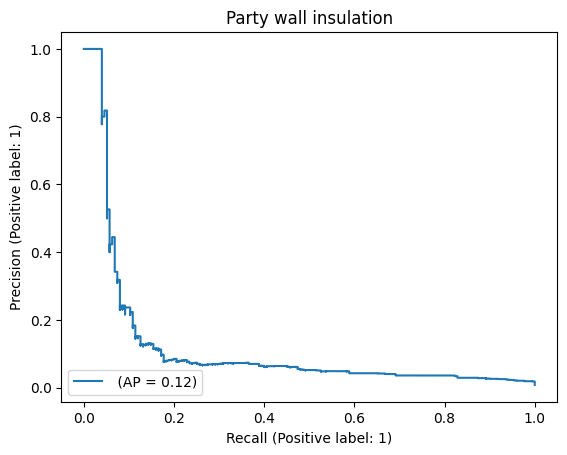

In [391]:
# plot individual precision-recall curve
class_number = 39
display = PrecisionRecallDisplay.from_estimator(
    multilabel_clf.estimators_[class_number], x_test, y_test[:,class_number], name=""
)
_ = display.ax_.set_title(id_to_text_mapper.iloc[class_number])

print(y_test[:,class_number].mean())
# print(id_to_text_mapper.iloc[0])


#### Performance tracker

In [387]:
tracker = pd.DataFrame(index=id_to_text_mapper)

In [388]:
set_name = '0'

In [389]:
tracker[set_name] = avg_prec_scores
tracker

,0
improvement_id_text,
Insulate hot water cylinder with 80 mm jacket,0.475
Increase hot water cylinder insulation,0.430
Add additional 80 mm jacket to hot water cylinder,0.233
Hot water cylinder thermostat,0.827
Increase loft insulation to 270 mm,0.300
Cavity wall insulation,0.351
50 mm internal or external wall insulation,0.827
Replace single glazed windows with low-E double glazing,0.990
Secondary glazing to single glazed windows,0.041


In [372]:
average_precision_score(y_test,prob_preds)

C:\Users\Joanna\anaconda3\envs\epc-analysis\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


0.5963552749378594

In [370]:
try:
    del prob_preds
except:
    pass

for p in multilabel_clf.predict_proba(x_test):
    p = p[:,1]
    try:
        prob_preds = np.vstack((prob_preds,p))
    except:
        prob_preds = p
        
prob_preds = prob_preds.T

In [371]:
prob_preds.shape

(21376, 40)

In [357]:
y_train[:,22].mean()

0.8338150289017341

In [345]:
y_test[:,class_number]

print(y_test[:,class_number].mean())

0.0


In [343]:
multilabel_clf.estimators_[class_number]

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', max_bin=256, max_cat_threshold=64,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=50, n_jobs=0,
                num_parallel_tree=50, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0, ...)

In [337]:
average_precision_score(y_test[:,class_number],
                        multilabel_clf.estimators_[class_number].predict_proba(x_test)[:,1])

0.9879456877833912

In [341]:
y_test[:,22].mean()

0.8345808383233533

In [247]:
# get the predicted probabilities for each estimator (class)
pred_probs = multilabel_clf.predict_proba(x_test)

# try:
#     del probs
# except:
#     pass

# for model_pred_probs in pred_probs:
#     col = model_pred_probs[:,1]
#     try:
#         probs = np.vstack((col, probs))
#     except:
#         probs = col

# pred_probs = probs.T

In [236]:
# need to set a threshold to determine pos/neg class
# for now will use the prop of pos classes over the total in training sample

thresholds = y_train.mean(axis=0)
thresholds

array([5.73356344e-03, 5.39984198e-02, 2.74930345e-02, 5.60620867e-02,
       1.38998628e-01, 1.63991350e-01, 1.92747536e-01, 5.21426789e-02,
       2.28718759e-04, 3.73279411e-02, 3.09591633e-01, 3.17087371e-03,
       7.64170167e-01, 3.21006778e-01, 1.03963072e-04, 4.36644904e-04,
       8.67052023e-03, 1.12695970e-02, 2.25599867e-03, 1.36711440e-02,
       0.00000000e+00, 2.06886514e-03, 8.33815029e-01, 5.94803926e-01,
       1.35151994e-04, 1.66340916e-04, 5.53083545e-03, 7.40321038e-02,
       2.67445004e-02, 2.64170167e-02, 2.39073481e-01, 1.30213748e-02,
       4.34045827e-03, 3.79413232e-02, 2.98270054e-02, 1.47637959e-01,
       1.69314260e-01, 1.08953300e-02, 1.49758806e-02, 9.41385620e-03])

In [243]:
(pred_probs[:,0]>=0.0057)

1.0

In [246]:
pred_probs[0]

array([0.11920302, 0.11920302, 0.11920307, 0.11920302, 0.11920302,
       0.11920302, 0.12191407, 0.11935707, 0.12044097, 0.11921258,
       0.12093788, 0.11929795, 0.12530541, 0.1192031 , 0.11922812,
       0.11922744, 0.11939782, 0.8725703 , 0.11920302, 0.11920302,
       0.11923425, 0.11920302, 0.11920302, 0.1192031 , 0.11920323,
       0.11920302, 0.1192754 , 0.80447435, 0.11921639, 0.12098651,
       0.12368072, 0.11920308, 0.1192256 , 0.12122215, 0.11920302,
       0.11921074, 0.11934887, 0.12020598, 0.1226717 , 0.11921386],
      dtype=float32)

In [221]:
np.vstack((col,col)).shape

(2, 21376)

In [208]:
pred_probs = multilabel_clf.predict_proba(x_test)
len(pred_probs)

40

In [197]:
multilabel_clf.predict(x_test)[:,0]

array([0, 0, 0, ..., 0, 0, 0])

In [504]:
multilabel_clf.predict(x_test).sum(axis=1)

array([1, 6, 2, ..., 2, 5, 3])

In [180]:
y_test.shape

(21376, 40)

In [251]:
preds = multilabel_clf.predict(x_test)


In [253]:
def get_accuracy_overall(pred, actual): return ((actual==pred).mean(axis=1)).mean()
get_accuracy_overall(preds,y_test)

0.9644519554640718

In [254]:
def get_accuracy_by_class(pred, actual): return (actual==pred).mean(axis=0)
get_accuracy_by_class(preds,y_test)

array([0.99560254, 0.94961639, 0.97338136, 0.97614147, 0.86236901,
       0.83387912, 0.92636602, 0.99719311, 0.99985966, 0.96753368,
       0.93927769, 0.99854978, 0.93983907, 0.79238398, 0.99995322,
       0.99990644, 0.99686564, 0.99752058, 0.99934506, 0.99887725,
       1.        , 0.9992515 , 0.97501871, 0.98666729, 0.99985966,
       0.99967253, 0.99990644, 0.97094873, 0.97492515, 0.97791916,
       0.94133608, 0.98671407, 0.99583645, 0.96453967, 0.97066804,
       0.86859094, 0.8412238 , 0.99438623, 0.99410554, 0.99204716])

In [262]:
y_test[:,1].sum(), y_train[:,1].sum()

(1173, 10388)

In [263]:
dummy_preds = np.zeros((y_test.shape))
get_accuracy_by_class(dummy_preds,y_test)

array([0.99429266, 0.94512537, 0.9732878 , 0.94063436, 0.86110591,
       0.83224177, 0.81184506, 0.94938249, 0.99985966, 0.96070359,
       0.69166355, 0.99700599, 0.23549775, 0.68085704, 0.99995322,
       0.99943862, 0.99055015, 0.98905314, 0.99728668, 0.98835142,
       1.        , 0.99831587, 0.16541916, 0.4034899 , 0.99985966,
       0.99967253, 0.99504117, 0.92500936, 0.9738024 , 0.97515906,
       0.75589446, 0.98568488, 0.99527507, 0.96430576, 0.97062126,
       0.85240457, 0.83280314, 0.98811751, 0.98404753, 0.99181325])

In [514]:
get_accuracy(preds,y_test)

0.9358392589820359

In [510]:
dummy_preds = np.zeros((y_test.shape))
get_accuracy(dummy_preds,y_test)

0.8898718188622754

In [494]:
multilabel_clf.feature_importances_

AttributeError: 'MultiOutputClassifier' object has no attribute 'feature_importances_'

In [517]:
clf = RandomForestClassifier()
    # objective='binary:logistic',
    # verbosity=1,
    # n_estimators = 1)

multilabel_clf = MultiOutputClassifier(clf)

# fit the model
multilabel_clf.fit(x_train[:50], y_train[:50])

# evaluate on test data
# print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, multilabel_model.predict(X_test))*100))

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values